# Clouds In Transmission

Notebook that shows all clouds functionalities and their effects (new and old)

[Deck + Haze](#Deck-Haze-Model)
<br><br>
[Mie Scatering Models](#Mie-Scattering-Cloud-Models)
<br><br>
[Mie Cloud Models](#Mie-Cloud-Models)

First, we define a planet that we will be using for the rest of the dictionary (Wasp-17b)

In [1]:
from POSEIDON.core import wl_grid_constant_R
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J, M_J
import scipy.constants as sc 
from POSEIDON.clouds import vary_one_parameter, contribution_clouds, plot_clouds

import numpy as np
import matplotlib.pyplot as plt

#***** Define stellar properties *****#

R_s = 1.49*R_Sun     # Stellar radius (m)
T_s = 6550            # Stellar effective temperature (K)
Met_s = -0.25          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.2        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'Clouds'  # Planet name used for plots, output files etc.

R_p = 1.87*R_J                           # Planetary radius (m)
R_p = 1.722*R_J
M_p = 0.78*M_J
g_p = (sc.G*M_p)/(R_p**2)         # Gravitational field of planet (m/s^2)
T_eq = 1447

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

CB_color_cycle = ['#0072B2', '#009E73', '#D55E00', '#CC79A7',
                 '#F0E442', '#56B4E9','#56B4E9']

# Intialize wavelength grid
wl_min = 0.2    # Minimum wavelength (um)
wl_max = 13      # Maximum wavelength (um)
R = 10000       # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p # Radius at reference pressure

/Users/elijahmullens/Desktop/POSEIDON-V1-1/POSEIDON/absorption.py:1494: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


In [2]:
from POSEIDON.core import read_opacities
from POSEIDON.core import define_model

model_name = 'Load-Opac'

bulk_species = ['H2','He']
param_species = ['H2O']

model_load_opac = define_model(model_name,bulk_species,param_species,
                               PT_profile = 'isotherm', X_profile = 'isochem')

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model_load_opac, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2O done
Opacity pre-interpolation complete.


# Deck Haze Model

This model implements an opaque cloud extending up to $P_{cloud}$ below which no electromagnetic radiation can pass through, and a haze that is uniformly distributed throughout the atmosphere. This model fits for both a flattening of a spectrum due to an opaque cloud deck and an 'amplified' short wavelngth slope that can obscure Na, K, TiO, VO, etc absorption features. 
<br><br>
Note that this model in a retrieval will fit for the short wavelength slope by design. However, the 'haze' in this model is a mathematical perscription and does not represent a 'real' molecule. See Mie Scattering sections for how to implement a 'real' aerosol or haze species. 
<br><br>
$\lambda_0$ is the reference wavelength (350 nm), $\sigma_0$ is the H2-Rayleigh scattering cross section at the reference wavelength (5.31e-31 $m^2$), a is the Rayleigh-enhancement factor and $\gamma$ is the scattering slope. 
<br><br>

$$
\begin{equation}
\kappa_{cloud}=
    \begin{cases}
        a \sigma_0 (\lambda / \lambda_0)^{\gamma} & P < P_{cloud}\\
        \infty & P \geq P_{cloud}
    \end{cases}
\end{equation}
$$

<br><br>

We will explore how each 'tunable' parameter affects a spectrum. 

In [3]:
from POSEIDON.core import define_model

model_name = 'Deck-Haze'

bulk_species = ['H2','He']
param_species = ['H2O']

model_deck_haze = define_model(model_name,bulk_species,param_species,
                               PT_profile = 'isotherm', X_profile = 'isochem',
                               cloud_model = 'MacMad17', cloud_type = 'deck_haze')

print("PT parameters : " + str(model_deck_haze['PT_param_names']))
print("X parameters : " + str(model_deck_haze['X_param_names']))
print("Cloud parameters : " + str(model_deck_haze['cloud_param_names']))

PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_a' 'gamma' 'log_P_cloud']


In [4]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_a       = 1.7
gamma       = -8 
log_P_cloud = -2

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = np.array([log_a, gamma, log_P_cloud])

# Make atmosphere 
atmosphere_deck_haze = make_atmosphere(planet, model_deck_haze, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

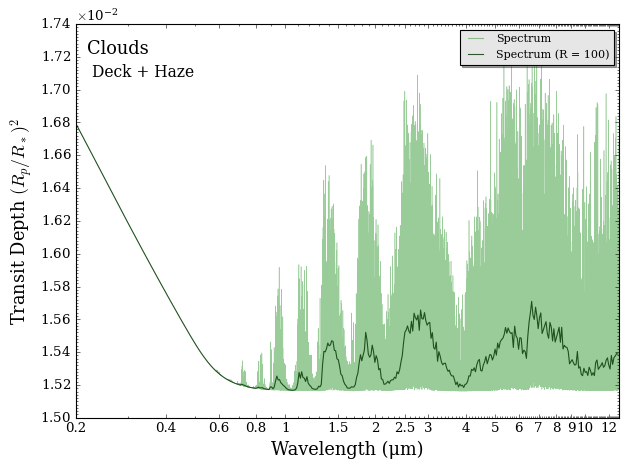

In [5]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate spectrum
spectrum_deck_haze = compute_spectrum(planet, star, model_deck_haze, atmosphere_deck_haze, opac, wl,
                                      spectrum_type = 'transmission')
# Plot spectrum
spectra = plot_collection(spectrum_deck_haze, wl, collection = [])

fig = plot_spectra(spectra, planet, R_to_bin = 100,
                   plt_label = 'Deck + Haze',
                   save_fig = False) 

Lets check out how the deck + haze is actually affecting the spectrum

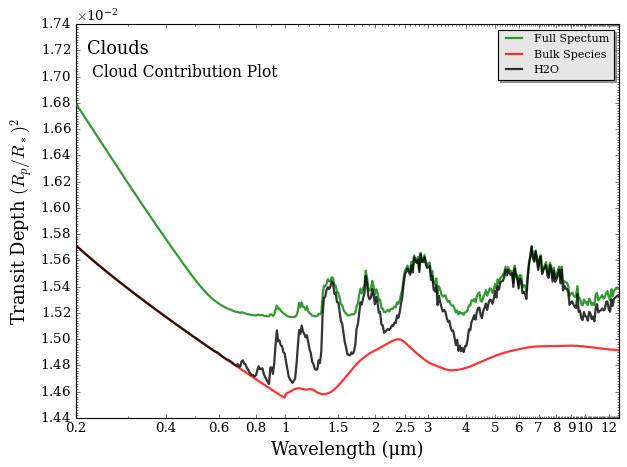

In [6]:
contribution_clouds(model_deck_haze, planet, star, wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Here we can see both the effects of the deck and the haze. The opaque cloud tends to flatten the spectrum after the UVIS slope. The slope dominates in the shorter wavelengths. We will now vary each parameter just to see how they work.

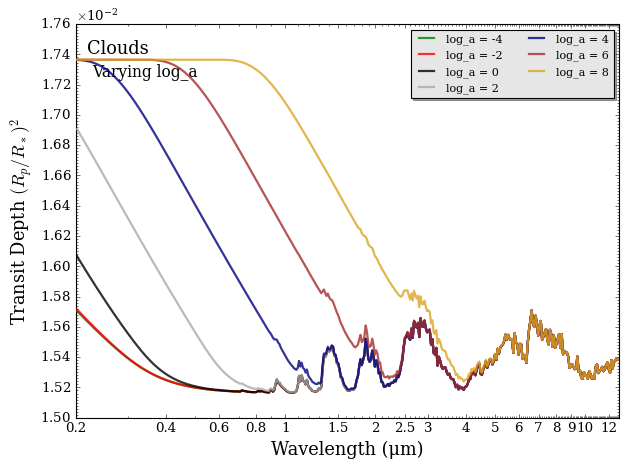

In [7]:
param_name = 'log_a'
vary_list = [-4,-2,0,2,4,6,8]

vary_one_parameter(model_deck_haze, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

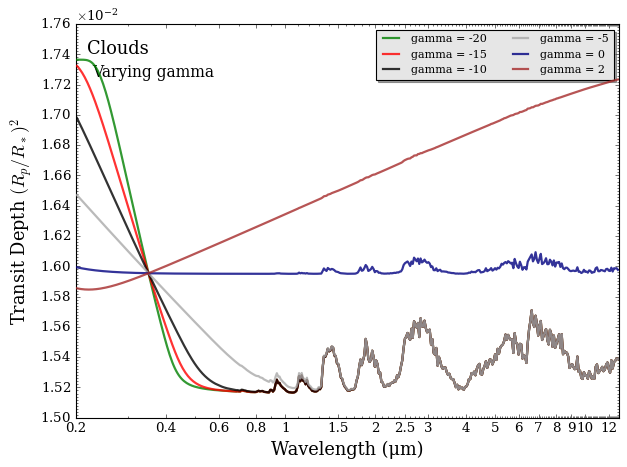

In [8]:
param_name = 'gamma'
vary_list = [-20,-15,-10,-5,0,2]

vary_one_parameter(model_deck_haze, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

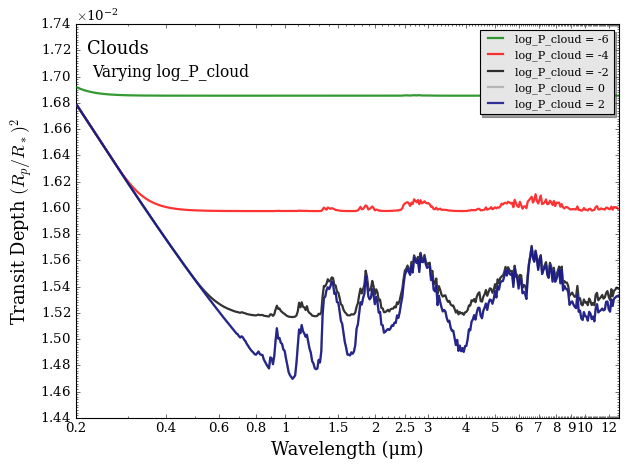

In [9]:
param_name = 'log_P_cloud'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter(model_deck_haze, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

# Mie Scattering Cloud Models

Please make sure that 

1) The refractive_indices folder (containing npy files) are in the input/opacity/refractive_indices and 
2) The aerosol_database.hdf5 is in the inputs/opacity folder

If aerosol_database.hd has not been created, run the following cell and it will be created from the refactive indices in 1

In [10]:
from POSEIDON.clouds import make_aerosol_database

make_aerosol_database()

---------------------
Loading in .npy files from
/Users/elijahmullens/Desktop/Poseidon-V1-1/inputs/opacity/refractive_indices/
---------------------
---------------------
Generating database from the following aerosols
---------------------
Al2O3
C
CH4
CaTiO3
Cr
ExoHaze_1000xSolar_300K
ExoHaze_1000xSolar_400K
Fe
Fe2O3
Fe2SiO4
FeO
FeS
FeSiO3
H2O
Hexene
KCl
Mg2SiO4
Mg2SiO4_Fe_poor
Mg4Fe6SiO3_amorph_glass
Mg5Fe5SiO3_amorph_glass
Mg8Fe12SiO4_amorph_glass
Mg8Fe2SiO3_amorph_glass
MgAl2O4
MgFeSiO4_amorph_glass
MgO
MgSiO3
MgSiO3_amorph_glass
MgSiO3_sol_gel
MnS
Na2S
NaCl
SiO
SiO2
SiO2_amorph
Tholin
---------------------
Saving new aerosol database as
/Users/elijahmullens/Desktop/Poseidon-V1-1/inputs/opacity/aerosol_database_emission.hdf5
---------------------


## Mie Aerosol Types

POSEIDON currently supports three different types of aerosol inputs. 

1) Aerosols in the database
2) User inputted aerosol lab data
2) Aersols with constant refractive indices

Aerosols in the database are computed from the refractive indices found in 
- Wakeford & Sing 2014 (https://arxiv.org/abs/1409.7594)
- Kitzmann & Heng 2017 (https://arxiv.org/abs/1710.04946)
- Chao et al 2023      (https://arxiv.org/pdf/2301.02745.pdf)

Each aerosol in the database has their effective extinction cross section ($\sigma_{eff,ext}$), effective absorption cross section ($\sigma_{eff,abs}$), effective scattering cross section ($\sigma_{eff,scat}$), effective back scattering cross section ($\sigma_{eff,back}$), effective asymmetry parameter ($g$), and effective single scattering albedo ($\omega$) calculated covering wavelengths from 0.2 to 30 um and particle sizes 0.001 to 10 um (log -3 to 1). 

Particles are assumed to be in a log normal distribution centered around the particle size recorded in the database. 
Aerosols are given a cross section of 0 in regions where refractive index lab data did not span the full 0.2-30 um. 

Cross sections were computed via the python LX-MIE algorithm, and functional forms from PyMieScatt 
- LX-MIE Algorithm (Kitzmann & Heng 2017, https://arxiv.org/abs/1710.04946)
- PLATON Aerosol Implementation (Zhang et al 2018, https://arxiv.org/abs/1811.11761)
- PyMieScatt Mie Efficiences (https://pymiescatt.readthedocs.io/en/latest/forward.html)
- (My paper eventually)

The log effective extinction cross section, asymmetry parameter, and single scattering albedo for species in the database can be found in aerosol_database.pdf in the same folder as this notebook.

Users can also input their own aerosol lab data to POSEIDON. POSEIDON will use the algorithm to calcualte the cross sections and other properties for any user inputted lab data 'on the fly'. This functionality is good for quick forward models. For retrievals, users can add their aerosol to the aerosol database. Precomputing aerosol properties can take 1-2 days. 

Finally, users can initialize a model with aerosols that have a constant refractive index over the entire wavelength range.

This section will only be covering aerosol specific properties. How to initialize models with the three different types of aerosol inputs + aerosol cloud models will be described in the next section

## 1. Aerosols in the Datbase 

Lets check the available species in the database.

In [11]:
from POSEIDON.supported_chemicals import aerosol_supported_species

print(aerosol_supported_species)

['Fe' 'NaCl' 'Fe2O3' 'MgSiO3' 'Mg2SiO4' 'Na2S' 'CH4' 'KCl' 'H2O' 'SiO'
 'SiO2' 'Tholin' 'Al2O3' 'C' 'CaTiO3' 'Cr' 'Fe2SiO4' 'FeO' 'FeS' 'FeSiO3'
 'Hexene' 'ExoHaze_1000xSolar_300K' 'ExoHaze_1000xSolar_400K'
 'Mg4Fe6SiO3_amorph_glass']


Lets query the database directly.

NOTE : Loading in the database directly as shown below is not necessary for running forward models and retrievals. This is just to display how to do so if you wish to explore the parameter space of an aerosol species

In [12]:
from POSEIDON.clouds import load_aerosol_grid, interpolate_sigma_Mie_grid
import matplotlib.pyplot as plt 

species = 'SiO2'

# Load in the grid 
aerosol_grid = load_aerosol_grid([species])

# Test to see if the cross sections come out with SiO2 particle, 0.01 um sized
r_m = 0.01

# This formula loads in the grid 
sigma_Mie_interp_array = interpolate_sigma_Mie_grid(aerosol_grid, wl, [r_m], [species],)

# Lets load in the cross sections, asymmetry parameter, and single scattering albedo 
eff_ext = sigma_Mie_interp_array[species]['eff_ext']
eff_abs = sigma_Mie_interp_array[species]['eff_abs']
eff_scat = sigma_Mie_interp_array[species]['eff_scat']
eff_back = sigma_Mie_interp_array[species]['eff_back']
eff_w = sigma_Mie_interp_array[species]['eff_w']
eff_g = sigma_Mie_interp_array[species]['eff_g']

Reading in database for aerosol cross sections...


I will only plot the effective extinction cross section, single scattering albedo, and asymmetry parameter. 

Currently, these are the only parameters that are being used in the forward models and retrievals. 

The effective extinction cross section is the total loss of photons due to scattering and absorption processes. This is used in transmission geometries.

The single scattering albedo ($\omega$) describes how 'forward-scattering' an aerosol is. 0 = Rayleigh limit (isotropic scattering) vs 1 = Forward Scattering. 

The asymmetry parameter ($g$) describes if an aerosol acts primarily as an absorber or a scatterer (0 = completely absorbs, 1 = completely scatters). This parameter can go negative, which means that its 'adding' photos back into the beam. 

$\omega$ and $g$ are used in emission geometries where multiple and forwarding scattering processes are important to consider. 

Here we see that SiO2 has an absorption feature around 8um and a scattering slope in the shorter wavelengths. The benefit to using real aerosols is that you get both a scattering slope and a longer wavelength absorption feature! 

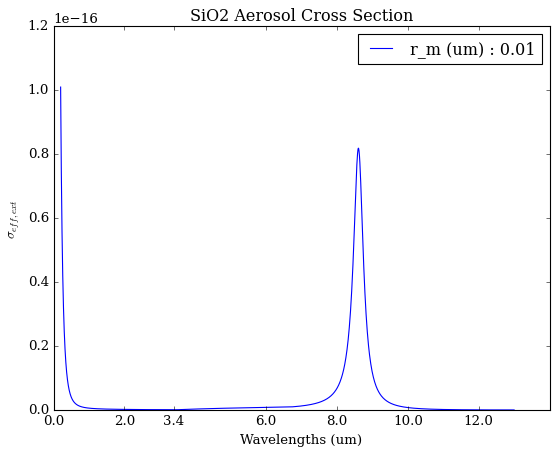

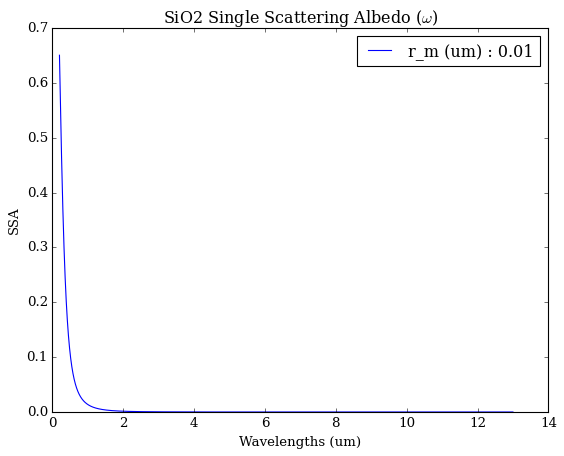

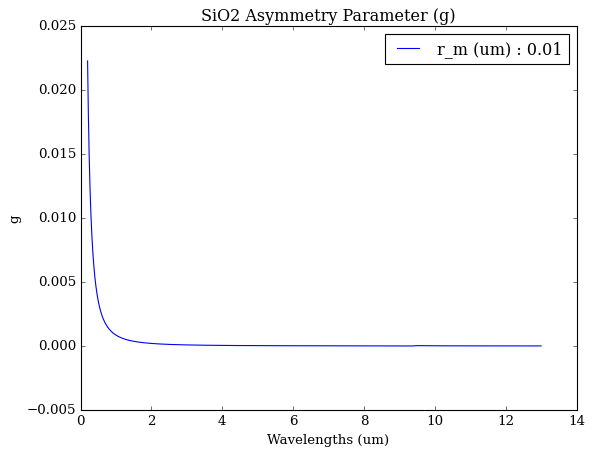

In [13]:
label = 'r_m (um) : ' + str(r_m)
title = species + ' Aerosol Cross Section'

plt.plot(wl,eff_ext, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('$\sigma_{eff,ext}$')
plt.xticks((0,2,3.4,6,8,10,12))
plt.show()

title = species + ' Single Scattering Albedo ($\omega$)'
plt.plot(wl,eff_w, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('SSA')
plt.show()


title =species + ' Asymmetry Parameter (g)'
plt.plot(wl,eff_g, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('g')
plt.show()

## 2. User-Inputted Aerosol

Here we will load in the H2O_complex txt file, which contains the refractive indices for H2O aerosols. Its reccomended to load in the refractive indices and load them into a couple of forward models to make sure they behave the way you expect. Then you can add them manually to the database for retrievals 

Lets load in an analyze the properties of the H2O txt file

NOTE : Calculating the aerosols properties will take 5-10 seconds since the properties are being directly computed

Loading in :  ./H2O_complex.txt


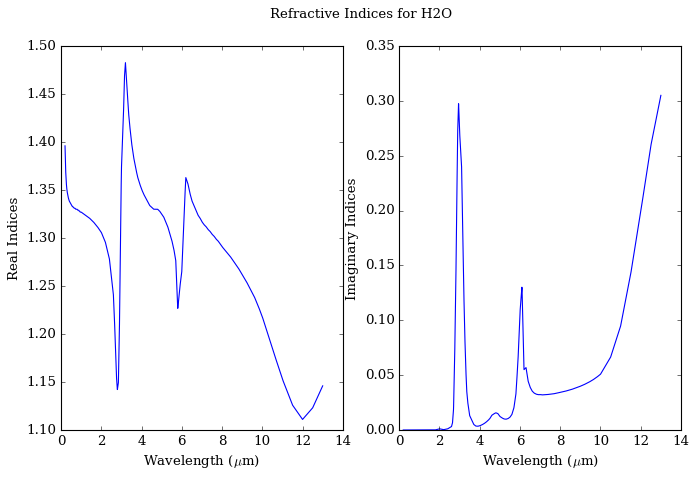

Loading in :  ./H2O_complex.txt


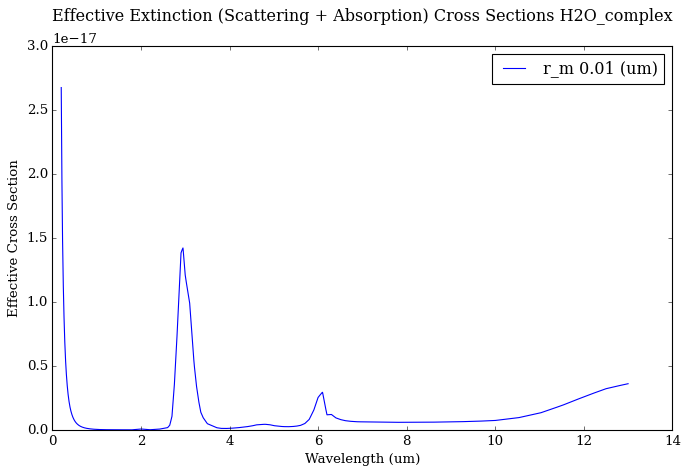

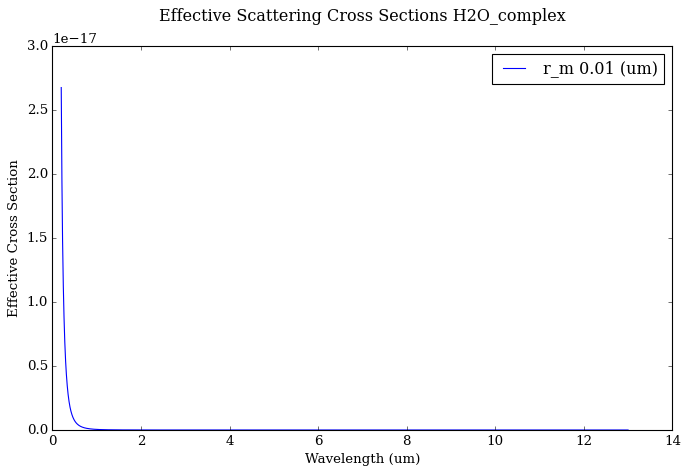

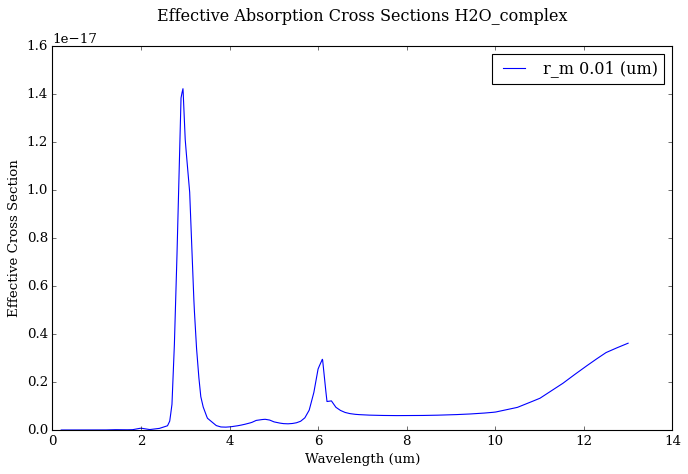

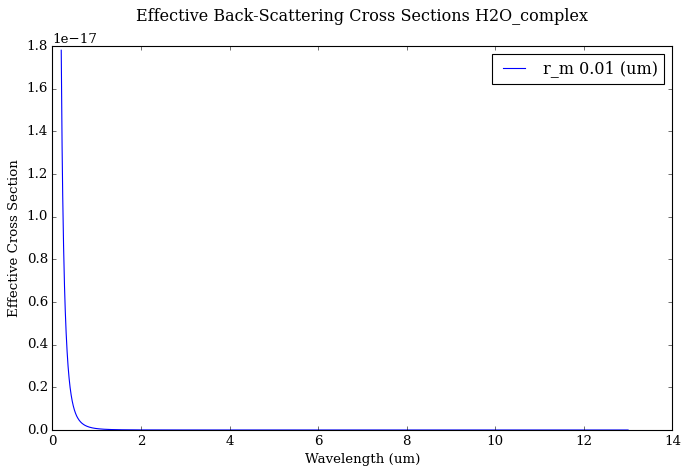

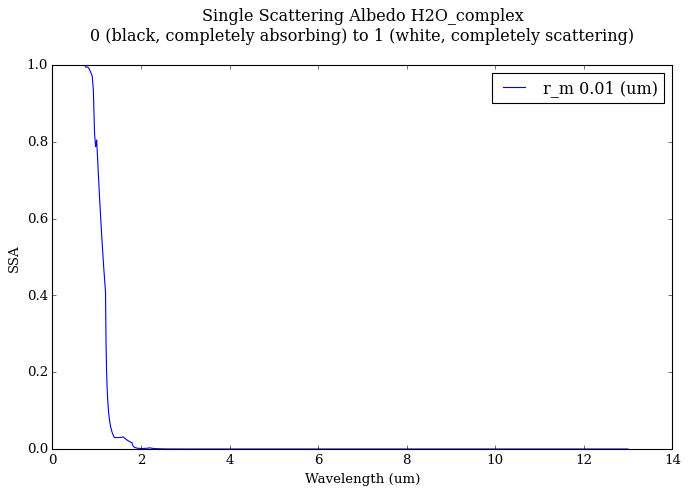

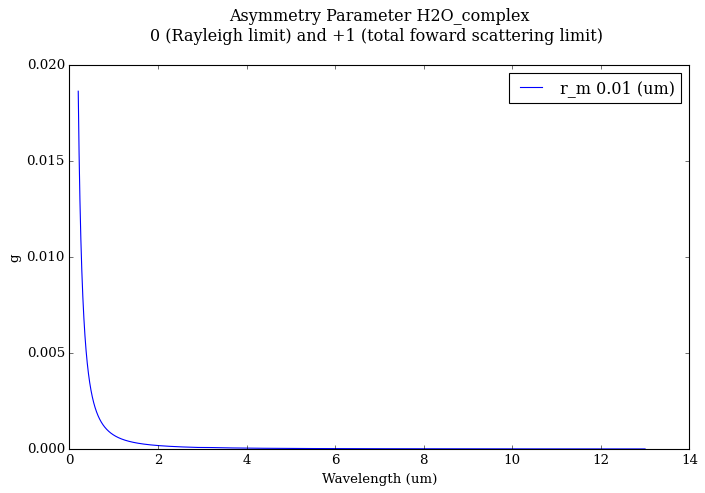

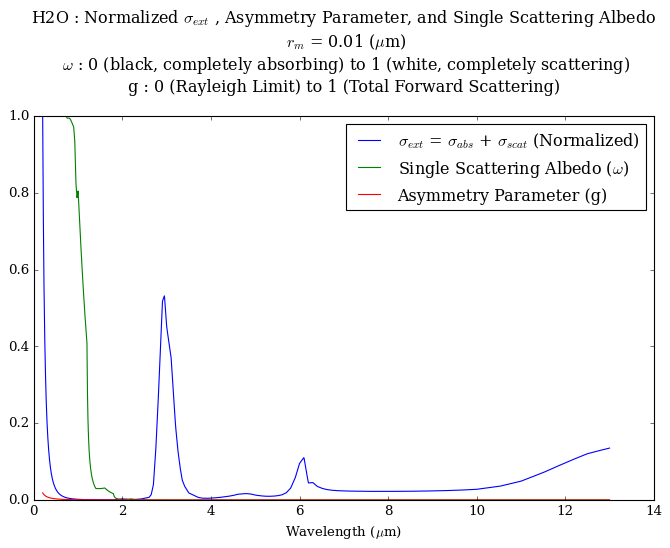

In [14]:
from POSEIDON.clouds import plot_refractive_indices_from_file, plot_effective_cross_section_from_file
import numpy as np 
from scipy.interpolate import interp1d

# First, lets check how the cross sections that our own file : 'H2O_complex.txt' makes
file_name = './H2O_complex.txt'

# Plotting the refractive indices 
plot_refractive_indices_from_file(wl, file_name)

# Plotting the cross section from LX_MIE 
r_m = 0.01 # mean particle size

plot_effective_cross_section_from_file(wl, r_m, file_name)

## 3. Constant Refractive Index 

Here, you just define the real and imaginary components of the refrative index, which will be assumed to be constant over wavelength space. 

As you can see below, this perscription will result in something similar to the haze shown before. 

In the future, the refractive index will be allowed to be a free parameter at specific wavelengths to freely retrieve aerosols (a technique used in solar system retrievals). Single scattering albedo retrievals will also be added in a similar way.

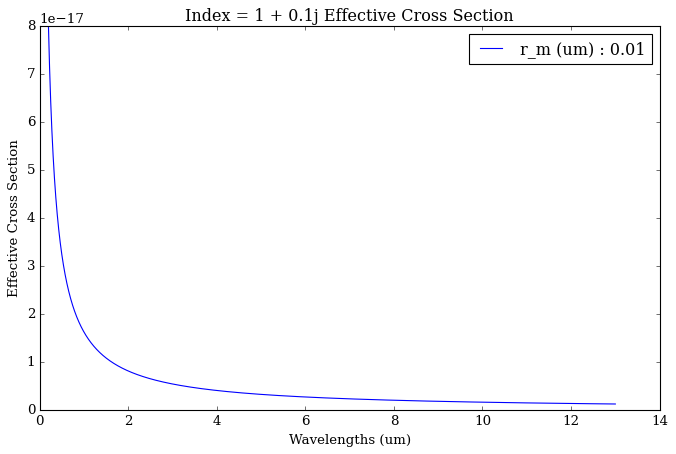

In [15]:
from POSEIDON.clouds import plot_effective_cross_section_free

r_m = 0.01  #um
r_i_real = 1
r_i_complex = 0.1

plot_effective_cross_section_free(wl, r_m, r_i_real, r_i_complex)

# Mie Cloud Models 

There are a few cloud models that are new and specific to Mie scattering. 

1. Fuzzy Deck Model 
2. Slab Model
3. Uniform X Model

Below, we will explore each model and how they imprint on spectra.

When defining a Mie scattering cloud model : 

1. Define your aerosol_species 
- Species name from the database (e.g. 'SiO2')
- 'file_read' if you are using your own aerosol data
- 'free' if its a constant refractive index

2. cloud_model = 'Mie'

3. cloud_type = 'fuzzy_deck', 'slab', 'uniform_X', 'opaque_deck_plus_slab', 'fuzzy_deck_plus_slab'

Each model allows for multiple aerosols (only for database species). For the deck_plus_slab model, it is assumed that the first aerosol species is the 'deck' species and the rest are slabs. 

# Fuzzy Deck Model

The fuzzy deck model is adapted from Zhang et al 2018 (https://arxiv.org/abs/1811.11761). In essence, this model is similar to the deck + haze described before in that there is an opaque cloud deck located at P_cloud plus an aerosol species above the deck. The free parametrs for a fuzzy deck model are : 

$log(P_{top,deck})$ : The pressure at which the opaque cloud ends 

$log(r_m)$     : The mean particle size in um (log = -3 -> 0.001 um)

$log(n_{max})$   : Maximum number density (defines the number density at log_P_cloud)

$f$           : fractional scale height (determines how 'fast' the number density falls off, 'fuzziness')

Note that if you are loading in your own refractive indices, or using a constant refractive index, you will also need to define : 

$r_{i,real}$ and $r_{i,complex}$ are the real and complex components of the refractive index for the free case. 

<br><br>

The number density of aerosols above the cloud deck is given by
$$
\begin{equation}
n = n_0 \; exp(\frac{-h}{f H_{gas}})
\end{equation} 
$$

where $h$ is the height above the cloud deck, $H_{gas}$ is the scale height

In [16]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Fuzzy_Deck_SiO2'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_fuzzy_deck = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'fuzzy_deck',
                     aerosol_species = aerosol_species)


# Check the free parameters defining this model
print("PT parameters : " + str(model_fuzzy_deck['PT_param_names']))
print("X parameters : " + str(model_fuzzy_deck['X_param_names']))
print("Cloud parameters : " + str(model_fuzzy_deck['cloud_param_names']))


Reading in database for aerosol cross sections...
PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_P_top_deck_SiO2' 'log_r_m_SiO2' 'log_n_max_SiO2' 'f_SiO2']


In [17]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_P_top_deck_SiO2 = 0
log_r_m_SiO2        = -2
log_n_max_SiO2      = 20
f_SiO2              = 0.3

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = np.array([log_P_top_deck_SiO2, log_r_m_SiO2, log_n_max_SiO2, f_SiO2])

# Make atmosphere 
atmosphere_fuzzy_deck = make_atmosphere(planet, model_fuzzy_deck, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Lets see this paramterization in action

1. In terms of number density 
2. In terms of mixing ratio 

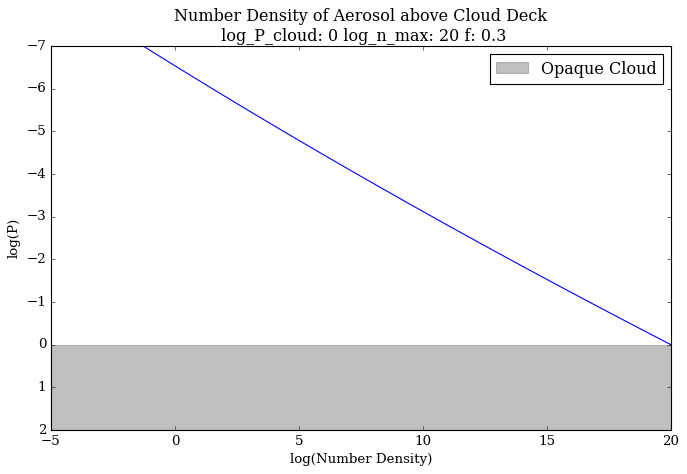

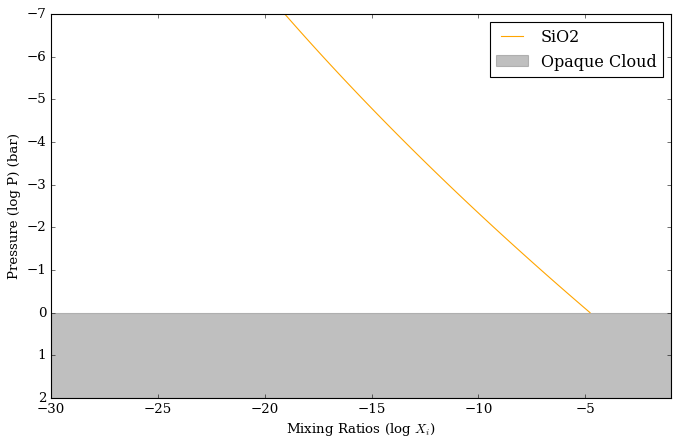

In [18]:
from POSEIDON.clouds import plot_aerosol_number_denstiy_fuzzy_deck, plot_clouds

plot_aerosol_number_denstiy_fuzzy_deck(atmosphere_fuzzy_deck,log_P_top_deck_SiO2,log_n_max_SiO2,f_SiO2)
plot_clouds(planet,model_fuzzy_deck,atmosphere_fuzzy_deck)

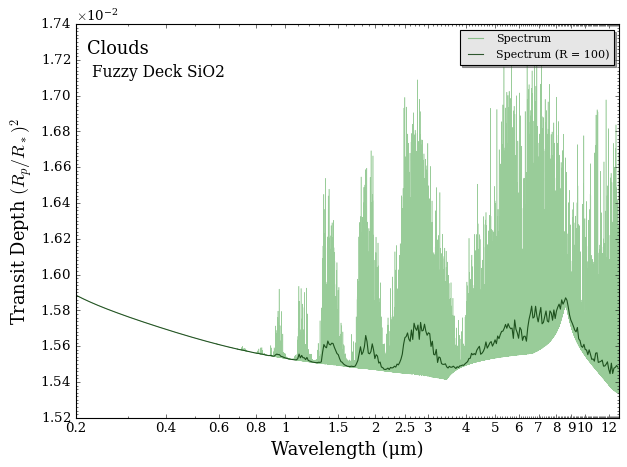

In [19]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate spectrum
spectrum_fuzzy_deck = compute_spectrum(planet, star, model_fuzzy_deck, atmosphere_fuzzy_deck, opac, wl,
                                      spectrum_type = 'transmission')
# Plot spectrum
spectra = plot_collection(spectrum_fuzzy_deck, wl, collection = [])

fig = plot_spectra(spectra, planet, R_to_bin = 100,
                   plt_label = 'Fuzzy Deck SiO2',
                   save_fig = False) 

Lets analyze whats going on 

Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...


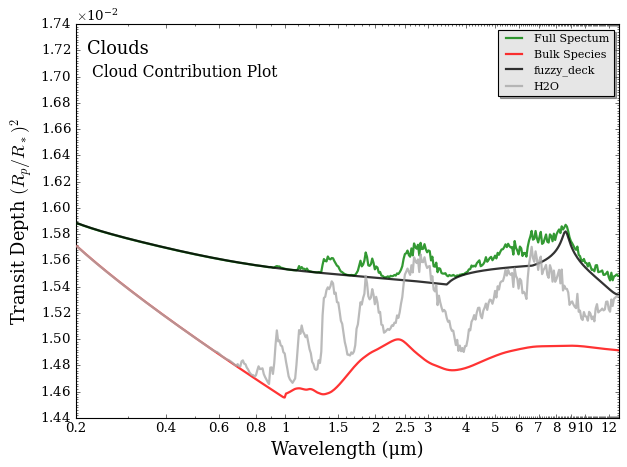

In [20]:
contribution_clouds(model_fuzzy_deck, planet, star, wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


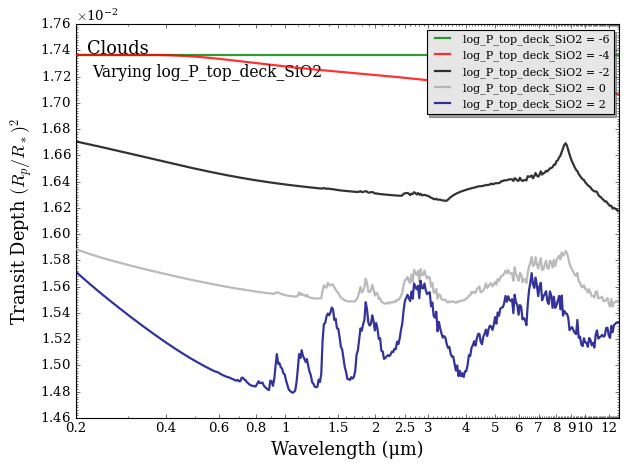

In [21]:
param_name = 'log_P_top_deck_SiO2'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


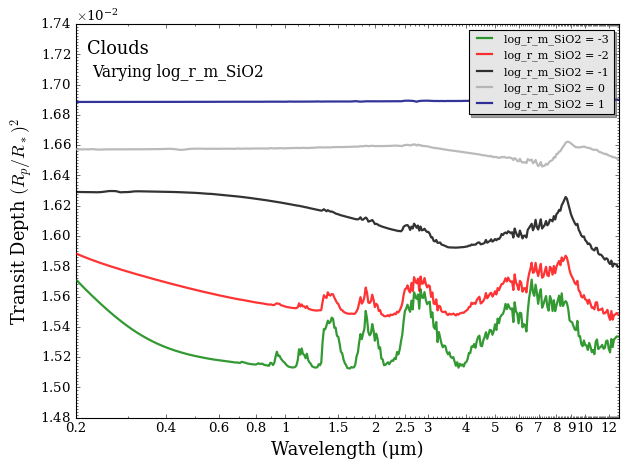

In [22]:
param_name = 'log_r_m_SiO2'
vary_list = [-3,-2,-1,0,1]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


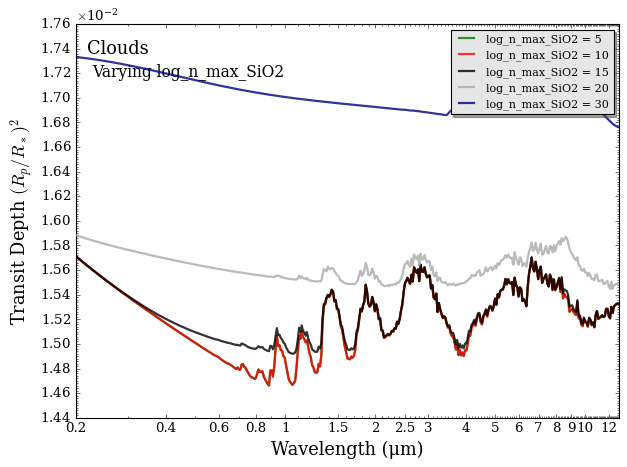

In [23]:
param_name = 'log_n_max_SiO2'
vary_list = [5,10,15,20,30]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


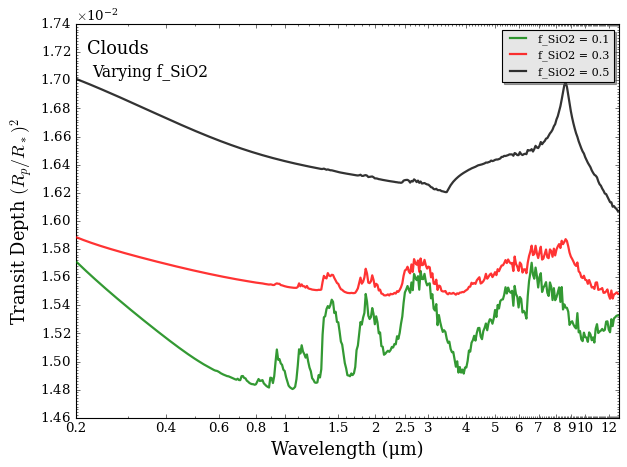

In [24]:
param_name = 'f_SiO2'
vary_list = [0.1,0.3, 0.5]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

# Slab

The slab model places a cloud spanning pressure space (from log_P_cloud_top to log_P_cloud_top + Delta_P) where an aerosol has a constant mixing ratio in that pressure range. The model is defined by : 

$log(P_{top, slab})$ : The pressure at which the top of the slab is located

$\Delta log(P)$ : The range the slab extends

$log(r_m)$     : The mean particle size in um (log = -3 -> 0.001 um)

$log(X)$        : Mixing ratio of aerosol species within the slab

Note that if you are loading in your own refractive indices, or using a constant refractive index, you will also need to define : 

$r_{i,real}$ and $r_{i,complex}$ are the real and complex components of the refractive index for the free case. 


In [32]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Slab_SiO2'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_slab = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'slab',
                     aerosol_species = aerosol_species)


# Check the free parameters defining this model
print("PT parameters : " + str(model_slab['PT_param_names']))
print("X parameters : " + str(model_slab['X_param_names']))
print("Cloud parameters : " + str(model_slab['cloud_param_names']))


Reading in database for aerosol cross sections...
PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2']


In [5]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_P_top_slab_SiO2 = -5
Delta_log_P_SiO2    = 2
log_r_m_SiO2        = -2
log_X_SiO2          = -12

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = ([log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2])

# Make atmosphere 
atmosphere_slab = make_atmosphere(planet, model_slab, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

NameError: name 'model_slab' is not defined

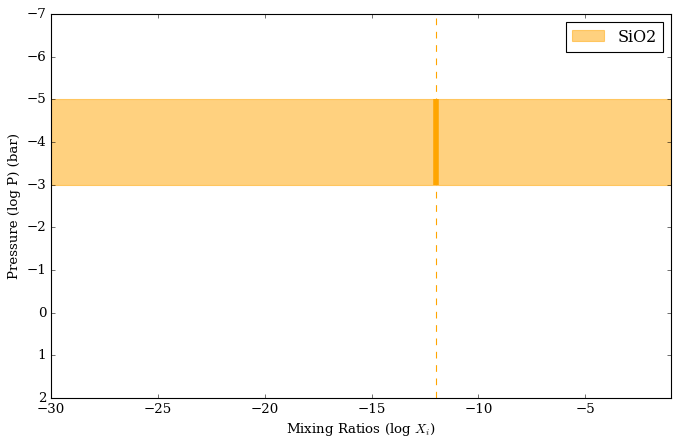

In [27]:
from POSEIDON.clouds import plot_clouds

plot_clouds(planet,model_slab,atmosphere_slab)

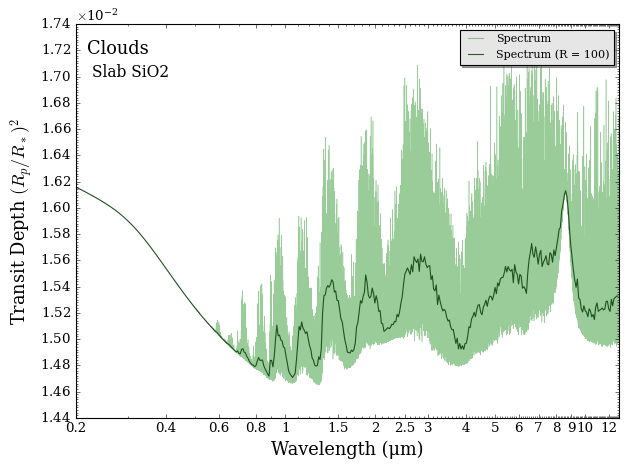

In [28]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate spectrum
spectrum_slab = compute_spectrum(planet, star, model_slab, atmosphere_slab, opac, wl,
                                      spectrum_type = 'transmission')
# Plot spectrum
spectra = plot_collection(spectrum_slab, wl, collection = [])

fig = plot_spectra(spectra, planet, R_to_bin = 100,
                   plt_label = 'Slab SiO2',
                   save_fig = False) 

Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...


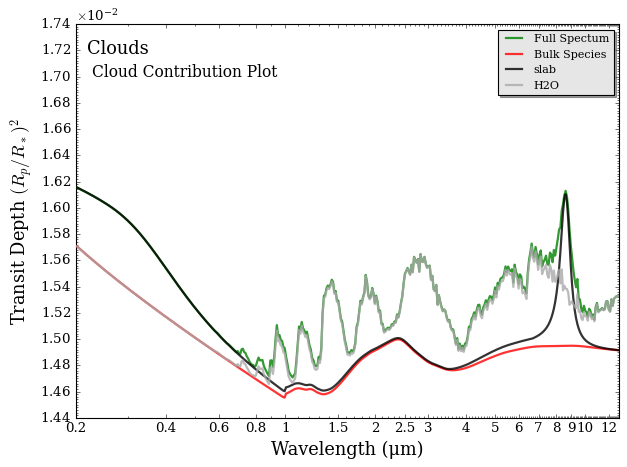

In [29]:
contribution_clouds(model_slab, planet, star, wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


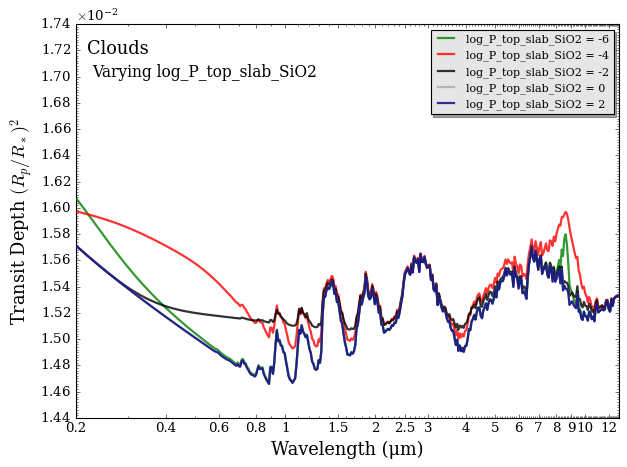

In [34]:
param_name = 'log_P_top_slab_SiO2'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


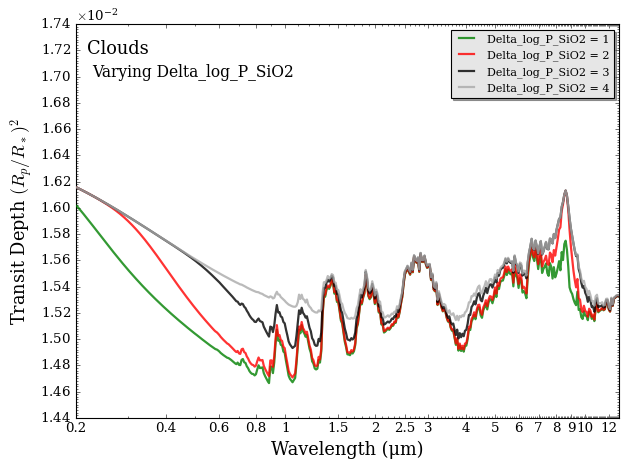

In [35]:
param_name = 'Delta_log_P_SiO2'
vary_list = [1,2,3,4]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


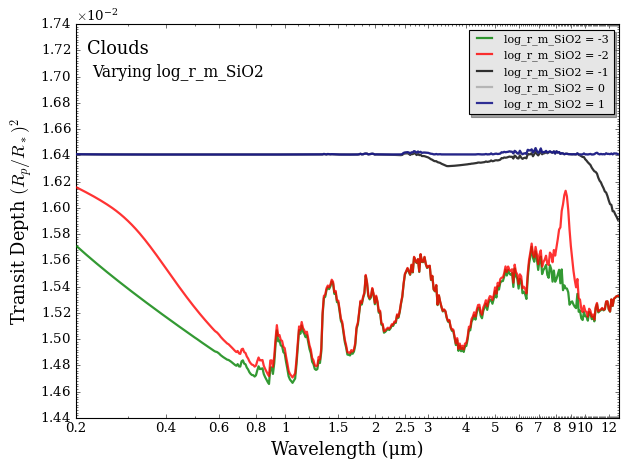

In [36]:
param_name = 'log_r_m_SiO2'
vary_list = [-3,-2,-1,0,1]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


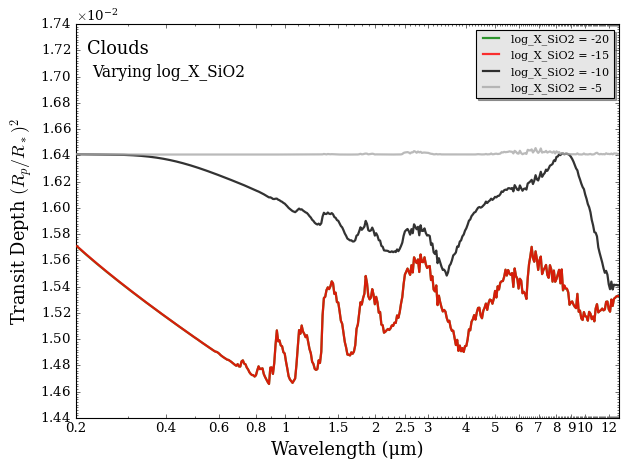

In [37]:
param_name = 'log_X_SiO2'
vary_list = [-20,-15,-10,-5]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

You can define multiple slabs! And also combine models

In [3]:
model_name = 'Multiple_Slabs'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']

aerosol_species = ['SiO2', 'MgSiO3']

model_multiple_slabs = define_model(model_name, bulk_species, param_species,
                                    PT_profile = 'isotherm', X_profile = 'isochem',
                                    cloud_model = 'Mie',cloud_type = 'slab',
                                    aerosol_species = aerosol_species)

model_name = 'Opaque_deck_plus_slab'

model_opaque_plus_slabs = define_model(model_name, bulk_species, param_species,
                                        PT_profile = 'isotherm', X_profile = 'isochem',
                                        cloud_model = 'Mie',cloud_type = 'opaque_deck_plus_slab',
                                        aerosol_species = aerosol_species)

model_name = 'Fuzzy_deck_plus_slab'
aerosol_species = ['Fe','SiO2', 'MgSiO3']

model_fuzzy_deck_plus_slabs = define_model(model_name, bulk_species, param_species,
                                            PT_profile = 'isotherm', X_profile = 'isochem',
                                            cloud_model = 'Mie',cloud_type = 'fuzzy_deck_plus_slab',
                                            aerosol_species = aerosol_species)

print()
print("Cloud parameters (slabs) : " + str(model_multiple_slabs['cloud_param_names']))
print()
print("Cloud parameters (opaque deck + slabs) : " + str(model_opaque_plus_slabs['cloud_param_names']))
print()
print("Cloud parameters (fuzzy deck + slabs) : " + str(model_fuzzy_deck_plus_slabs['cloud_param_names']))

Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...
This mode assumes that the first aerosol in the list is the deck species, rest are slab species
Reading in database for aerosol cross sections...

Cloud parameters (slabs) : ['log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3'
 'log_X_MgSiO3']

Cloud parameters (opaque deck + slabs) : ['log_P_top_deck' 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2'
 'log_X_SiO2' 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3'
 'log_r_m_MgSiO3' 'log_X_MgSiO3']

Cloud parameters (fuzzy deck + slabs) : ['log_P_top_deck_Fe' 'log_r_m_Fe' 'log_n_max_Fe' 'f_Fe'
 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3'
 'log_X_MgSiO3']


In [16]:
# PT and X parameters
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Slabs 
log_P_top_slab_SiO2 = -5
Delta_log_P_SiO2    = 1
log_r_m_SiO2        = -2
log_X_SiO2          = -12

log_P_top_slab_MgSiO3 = - 3
Delta_log_P_MgSiO3    = 1
log_r_m_MgSiO3        = -2
log_X_MgSiO3          = -13

cloud_params = ([log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2, 
                 log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3,log_X_MgSiO3])
                 
atmosphere_multiple_slabs = make_atmosphere(planet, model_multiple_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)


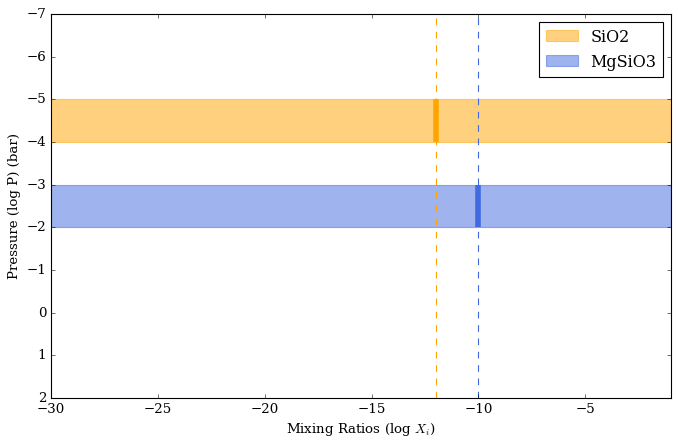

Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...


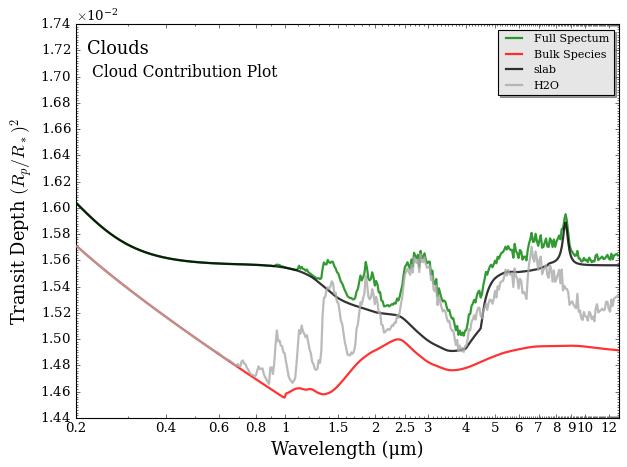

In [15]:
plot_clouds(planet,model_multiple_slabs,atmosphere_multiple_slabs)
contribution_clouds(model_multiple_slabs, planet, star, wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

In [6]:
# Opaque + Slabs
log_P_top_deck        = 1

cloud_params = ([log_P_top_deck,
                 log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2,
                 log_P_top_slab_MgSiO3,Delta_log_P_MgSiO3, log_r_m_MgSiO3,log_X_MgSiO3])

atmosphere_opaque_plus_slabs = make_atmosphere(planet, model_opaque_plus_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

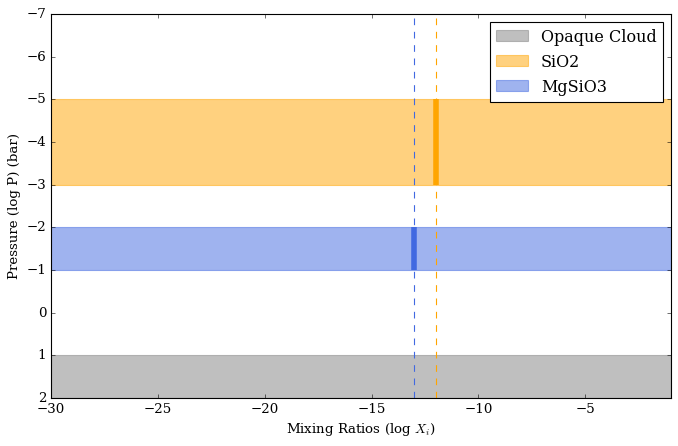

Reading in database for aerosol cross sections...
0
1
2
Reading in database for aerosol cross sections...
0
1
2


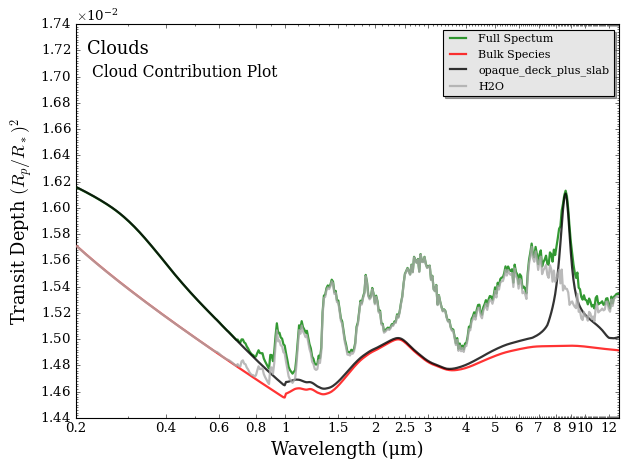

In [7]:
plot_clouds(planet,model_opaque_plus_slabs,atmosphere_opaque_plus_slabs)
contribution_clouds(model_opaque_plus_slabs, planet, star, wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

In [10]:
# Fuzzy Deck + Slabs
log_P_top_deck_Fe     = 1
log_r_m_Fe            = -2
log_n_max_Fe          = 20
f_Fe                  = 0.3


cloud_params = ([log_P_top_deck_Fe,log_r_m_Fe,log_n_max_Fe,f_Fe,
                 log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2,
                 log_P_top_slab_MgSiO3,Delta_log_P_MgSiO3,log_r_m_MgSiO3,log_X_MgSiO3])

atmosphere_fuzzy_deck_plus_slabs = make_atmosphere(planet, model_fuzzy_deck_plus_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

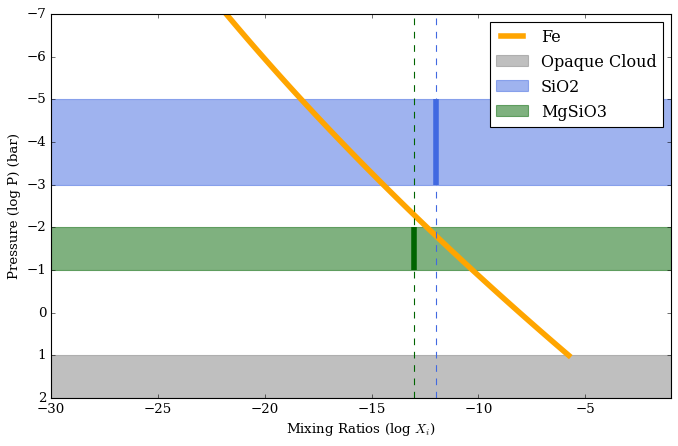

This mode assumes that the first aerosol in the list is the deck species, rest are slab species
Reading in database for aerosol cross sections...
0
1
2
3
This mode assumes that the first aerosol in the list is the deck species, rest are slab species
Reading in database for aerosol cross sections...
0
1
2
3


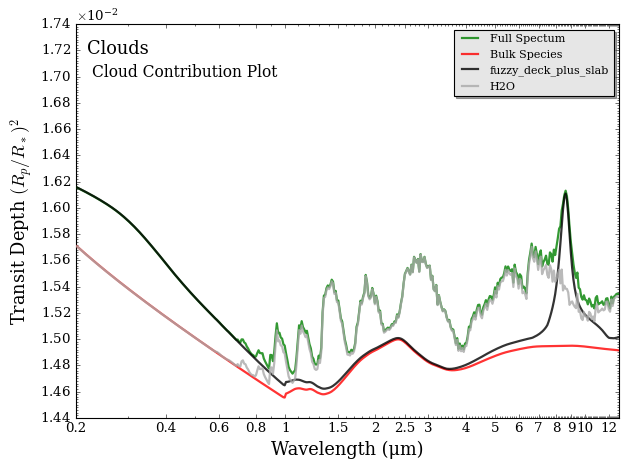

In [11]:
plot_clouds(planet,model_fuzzy_deck_plus_slabs,atmosphere_fuzzy_deck_plus_slabs)
contribution_clouds(model_fuzzy_deck_plus_slabs, planet, star, wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

## Uniform X 

# Retrievals (soon ;) )

This module works with retrievals. Follow other tutorials for how to set priors and run the retirevals. 

# Adding your own aerosols

### Option 1 : Aerosol = 'file_read'

This option is reccomended for forward models for quick testing

### Option 2 : Directly add an aerosol to the database

This option is reccomended if retrievals will be run using some lab data. 

To add your own lab data to the database for personal use, please refer to clouds_make_database and run 

precompute_cross_sections_one_aerosol(aerosol)

Ensure that the txt file is in input/refractive_indices with the two first lines being a header, the first column being wavelengths (um) spanning at least 0.2 to 30 um, second column being the real indices, and the third column being the imaginary indices. The txt file should be named aerosol + '_complex.txt

This function will load in a txt file at : input_file_path + 'refractive_indices/' + aerosol + '_complex.txt'

Computing the npy array of cross sections should take about a day. However, good news is that you only have to do it once! Now you don't have to wait around for Qext calculations. 

To add this to the database, run make_aerosol_database()

In [ ]:
from POSEIDON.clouds_make_database import precompute_cross_sections_one_aerosol

precompute_cross_sections_one_aerosol(file_name,'H2O')

Loading in :  ./H2O_complex.txt
Generating .npy file of cross sections for H2O
This will take approximately 1 day. Every 10 iterations, the current r_m is printed.
0.001


KeyboardInterrupt: 

In [ ]:
from POSEIDON.clouds_make_database import make_aerosol_database

make_aerosol_database()

---------------------
Loading in .npy files from
/Users/elijahmullens/Desktop/Poseidon-V1-1/inputs/opacity/refractive_indices/
---------------------
---------------------
Generating database from the following aerosols
---------------------
Tholin
Fe
Na2S
SiO2_amorph
MgO
SiO2
Mg2SiO4_amorph_sol_gel
Fe2O3
MgSiO3
KCl
H2O
NaCl
CH4
---------------------
Saving new aerosol database as
/Users/elijahmullens/Desktop/Poseidon-V1-1/inputs/aerosol_database.hdf5
---------------------


Load in the grid to make sure it works

# Next : Check out the clouds-emission tutorial!

# Future : Imaginary Index Retrievals